# Phase I: Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset (use correct file if using preview version)
data = pd.read_csv("covidcast_new-1.csv")
print("Data shape:", data.shape)
data.head()


Data shape: (25626, 19)


,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,1/7/2021,1000,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,29.288429,30.487852,57.334785,3.244379,2.6382,28.469582,18.571266,9.482316,24.962112,84.311759,12.627098
1,1/7/2021,1003,32.814153,10.189340,1.270183,61.516584,25.179399,51.160278,NaN,28.384842,53.172285,1.199572,NaN,27.532881,23.406516,8.933682,28.864558,82.778220,11.727249
2,1/7/2021,1015,35.621311,14.591271,6.594649,NaN,NaN,54.503711,NaN,37.003522,NaN,3.890709,NaN,NaN,20.974363,NaN,NaN,NaN,13.255336
3,1/7/2021,1051,40.453615,14.164503,3.320922,68.718538,19.438763,54.948755,NaN,37.637900,67.550815,3.284647,NaN,30.223647,20.009477,7.570250,26.494057,86.587182,13.823318
4,1/7/2021,1069,39.228766,10.103564,0.288897,59.961036,23.065494,60.118290,NaN,36.156326,55.995745,1.881970,NaN,30.806929,16.574756,12.916249,24.747620,85.825453,10.258936


# Phase II: Data Cleaning & Feature Exploration

## Initial Data Exploration

In [2]:
# === Initial data exploration ===

print("Dataset Shape:", data.shape)

# Check missing values in target variables
print("\nMissing values in target variables:")
print("Vaccine uptake:", data['smoothed_wcovid_vaccinated'].isna().sum())
print("COVID test positivity:", data['smoothed_wtested_positive_14d'].isna().sum())

# Split data into labeled and unlabeled sets for COVID positivity modeling
labeled_data = data.dropna(subset=['smoothed_wtested_positive_14d'])
unlabeled_data = data[data['smoothed_wtested_positive_14d'].isna()]

print(f"\nLabeled data shape: {labeled_data.shape}")
print(f"Unlabeled data shape: {unlabeled_data.shape}")


Dataset Shape: (25626, 19)

Missing values in target variables:
Vaccine uptake: 2602
COVID test positivity: 21632

Labeled data shape: (3994, 19)
Unlabeled data shape: (21632, 19)


## Feature Selection

In [7]:
# === Feature selection ===

# Original list of hand-picked features
features = [
    'smoothed_wcli', 'smoothed_wtested_14d',
    'smoothed_wwearing_mask', 'smoothed_wothers_masked',
    'smoothed_wwork_outside_home_1d', 'smoothed_wlarge_event_1d',
    'smoothed_wrestaurant_1d', 'smoothed_wshop_1d',
    'smoothed_wspent_time_1d', 'smoothed_wpublic_transit_1d',
    'smoothed_wworried_become_ill',
    'smoothed_wvaccine_likely_friends', 'smoothed_wvaccine_likely_who',
    'smoothed_wvaccine_likely_govt_health', 'smoothed_wvaccine_likely_politicians'
]

# Ensure all features exist in the dataset
missing_features = [f for f in features if f not in data.columns]
if missing_features:
    print(f"Warning: These features are not in the dataset: {missing_features}")
    features = [f for f in features if f in data.columns]

print(f"\nSelected features for modeling: {len(features)}")



Selected features for modeling: 15


## Proxy Model Training

In [8]:
# === Proxy model training (Random Forest) ===

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

X_labeled = labeled_data[features]
y_labeled = labeled_data['smoothed_wtested_positive_14d']

feature_imputer = SimpleImputer(strategy='mean')
X_labeled_imputed = feature_imputer.fit_transform(X_labeled)

X_train, X_val, y_train, y_val = train_test_split(X_labeled_imputed, y_labeled, test_size=0.2, random_state=42)

proxy_model = RandomForestRegressor(n_estimators=100, random_state=42)
proxy_model.fit(X_train, y_train)

y_val_pred = proxy_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\nProxy Model Performance on Validation Set:")
print(f"MSE: {val_mse:.4f}")
print(f"R²: {val_r2:.4f}")



Proxy Model Performance on Validation Set:
MSE: 13.3398
R²: 0.7747


## Pseudo-label Generation

In [9]:
# === Generate pseudo-labels and combine datasets ===

X_unlabeled = unlabeled_data[features]
X_unlabeled_imputed = feature_imputer.transform(X_unlabeled)

pseudo_labels = proxy_model.predict(X_unlabeled_imputed)

unlabeled_with_pseudo = unlabeled_data.copy()
unlabeled_with_pseudo['smoothed_wtested_positive_14d'] = pseudo_labels

combined_data = pd.concat([labeled_data, unlabeled_with_pseudo])
combined_data['is_real_label'] = combined_data.index.isin(labeled_data.index)

print(f"\nCombined Dataset Shape: {combined_data.shape}")
print(f"Real labels: {combined_data['is_real_label'].sum()}")
print(f"Pseudo-labels: {combined_data.shape[0] - combined_data['is_real_label'].sum()}")



Combined Dataset Shape: (25626, 20)
Real labels: 3994
Pseudo-labels: 21632


## Final Model Training on Combined Dataset

In [10]:
# === Train final model on labeled + pseudo-labeled data ===

from sklearn.model_selection import StratifiedShuffleSplit

X_combined = combined_data[features]
y_combined = combined_data['smoothed_wtested_positive_14d']
X_combined_imputed = feature_imputer.fit_transform(X_combined)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(X_combined_imputed, combined_data['is_real_label']):
    X_train_combined = X_combined_imputed[train_idx]
    y_train_combined = y_combined.iloc[train_idx]
    X_test_combined = X_combined_imputed[test_idx]
    y_test_combined = y_combined.iloc[test_idx]
    test_is_real = combined_data['is_real_label'].iloc[test_idx]

final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train_combined, y_train_combined)


RandomForestRegressor(random_state=42)

## Final Evaluation

In [12]:
# === Evaluation: Full test set and real-labeled only subset ===

y_test_pred = final_model.predict(X_test_combined)
test_mse = mean_squared_error(y_test_combined, y_test_pred)
test_r2 = r2_score(y_test_combined, y_test_pred)

print("\nFinal Model Performance (Overall Test Set):")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# Evaluate on real labels only
real_mask = test_is_real.values
if real_mask.sum() > 0:
    real_test_mse = mean_squared_error(y_test_combined[real_mask], y_test_pred[real_mask])
    real_test_r2 = r2_score(y_test_combined[real_mask], y_test_pred[real_mask])
    print("\nFinal Model Performance (Real Labels Only):")
    print(f"MSE: {real_test_mse:.4f}")
    print(f"R²: {real_test_r2:.4f}")



Final Model Performance (Overall Test Set):
MSE: 2.5809
R²: 0.9248

Final Model Performance (Real Labels Only):
MSE: 11.7725
R²: 0.8050


## Feature Importance & Prediction Storage


Top 10 Important Features:
                                 Feature  Importance
0                          smoothed_wcli    0.560003
9            smoothed_wpublic_transit_1d    0.124161
6                smoothed_wrestaurant_1d    0.075517
3                smoothed_wothers_masked    0.049280
14  smoothed_wvaccine_likely_politicians    0.033585
10          smoothed_wworried_become_ill    0.029933
7                      smoothed_wshop_1d    0.026904
5               smoothed_wlarge_event_1d    0.021012
4         smoothed_wwork_outside_home_1d    0.018657
1                   smoothed_wtested_14d    0.016222


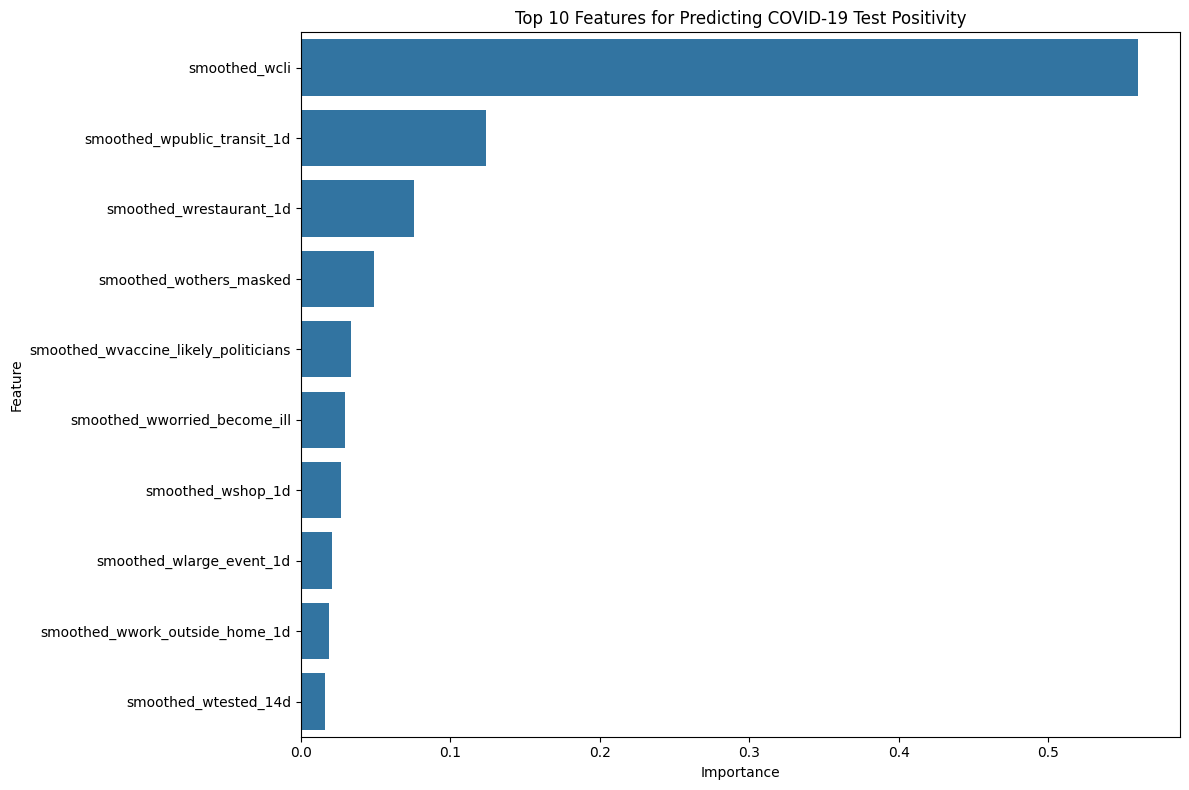

In [13]:
# === Feature importance + save predictions ===

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for Predicting COVID-19 Test Positivity')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Save predictions to main dataset
data['predicted_wtested_positive_14d'] = np.nan
data.loc[unlabeled_data.index, 'predicted_wtested_positive_14d'] = pseudo_labels
data.loc[labeled_data.index, 'predicted_wtested_positive_14d'] = labeled_data['smoothed_wtested_positive_14d']


## Distribution of Input Features

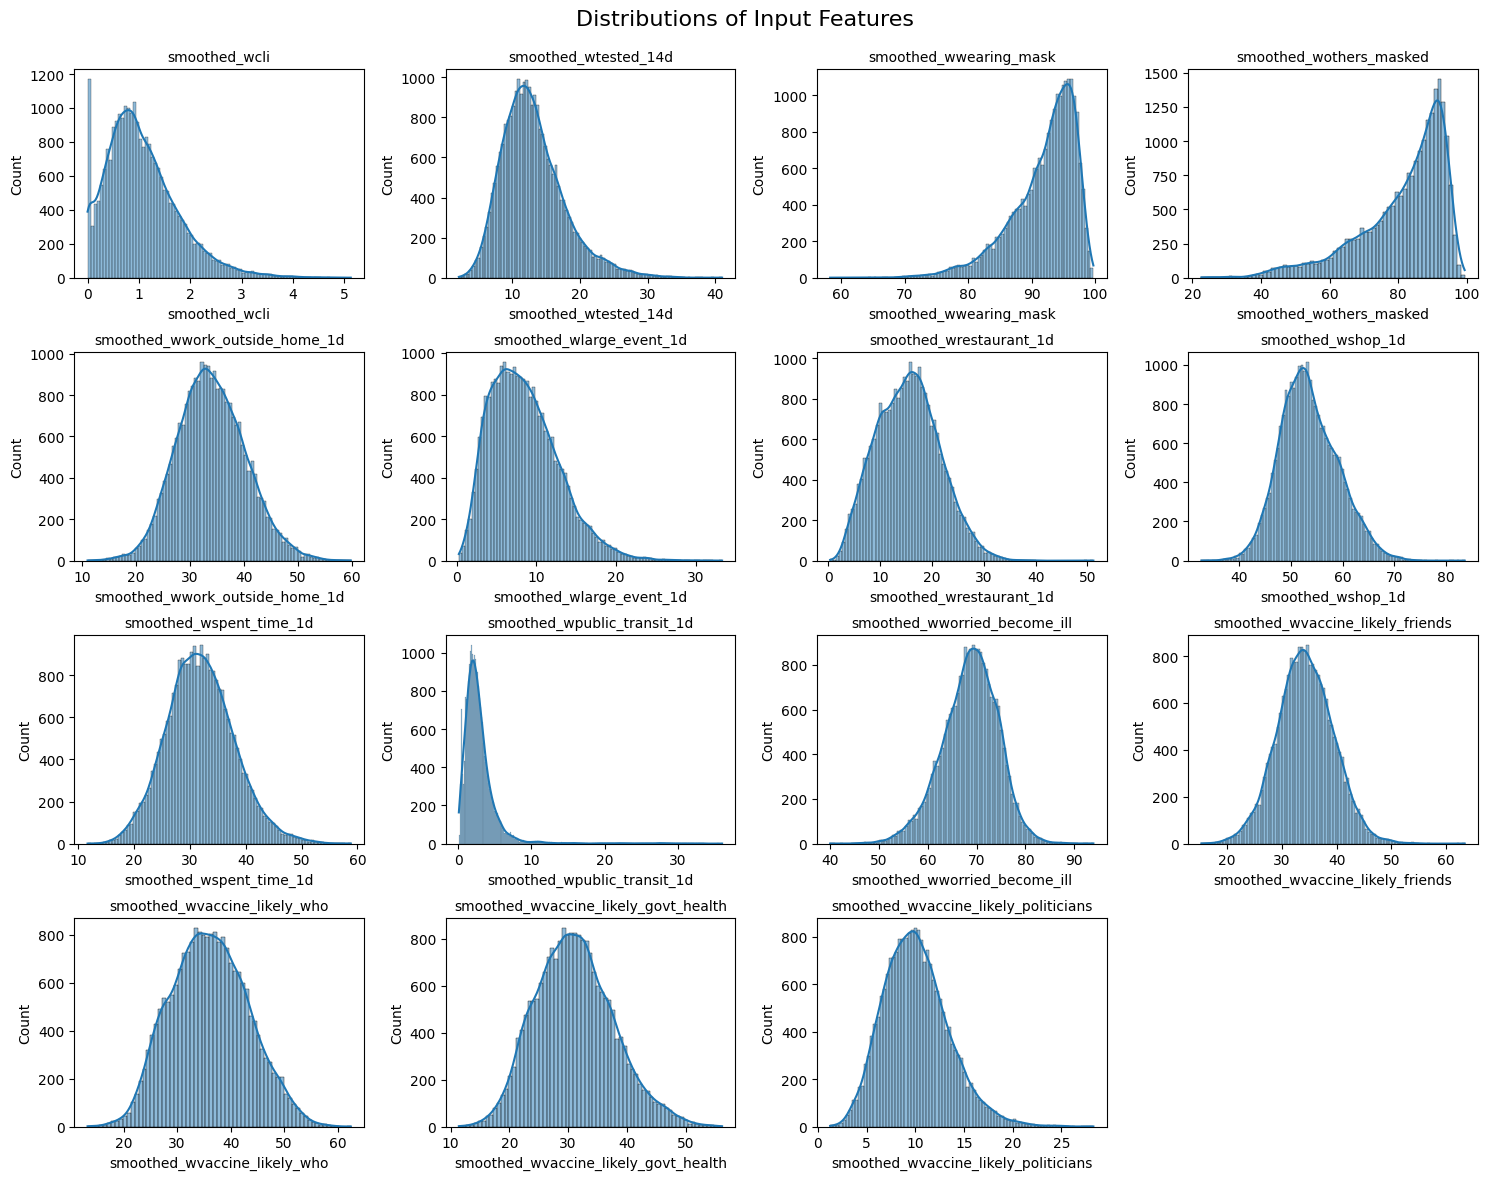

In [14]:
# Check for outliers and visualize distributions of all features
# === Data Cleaning: Distribution of Features ===
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(feature, fontsize=10)
    plt.tight_layout()
plt.suptitle("Distributions of Input Features", fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()

## Correlation Matrix & Heatmap

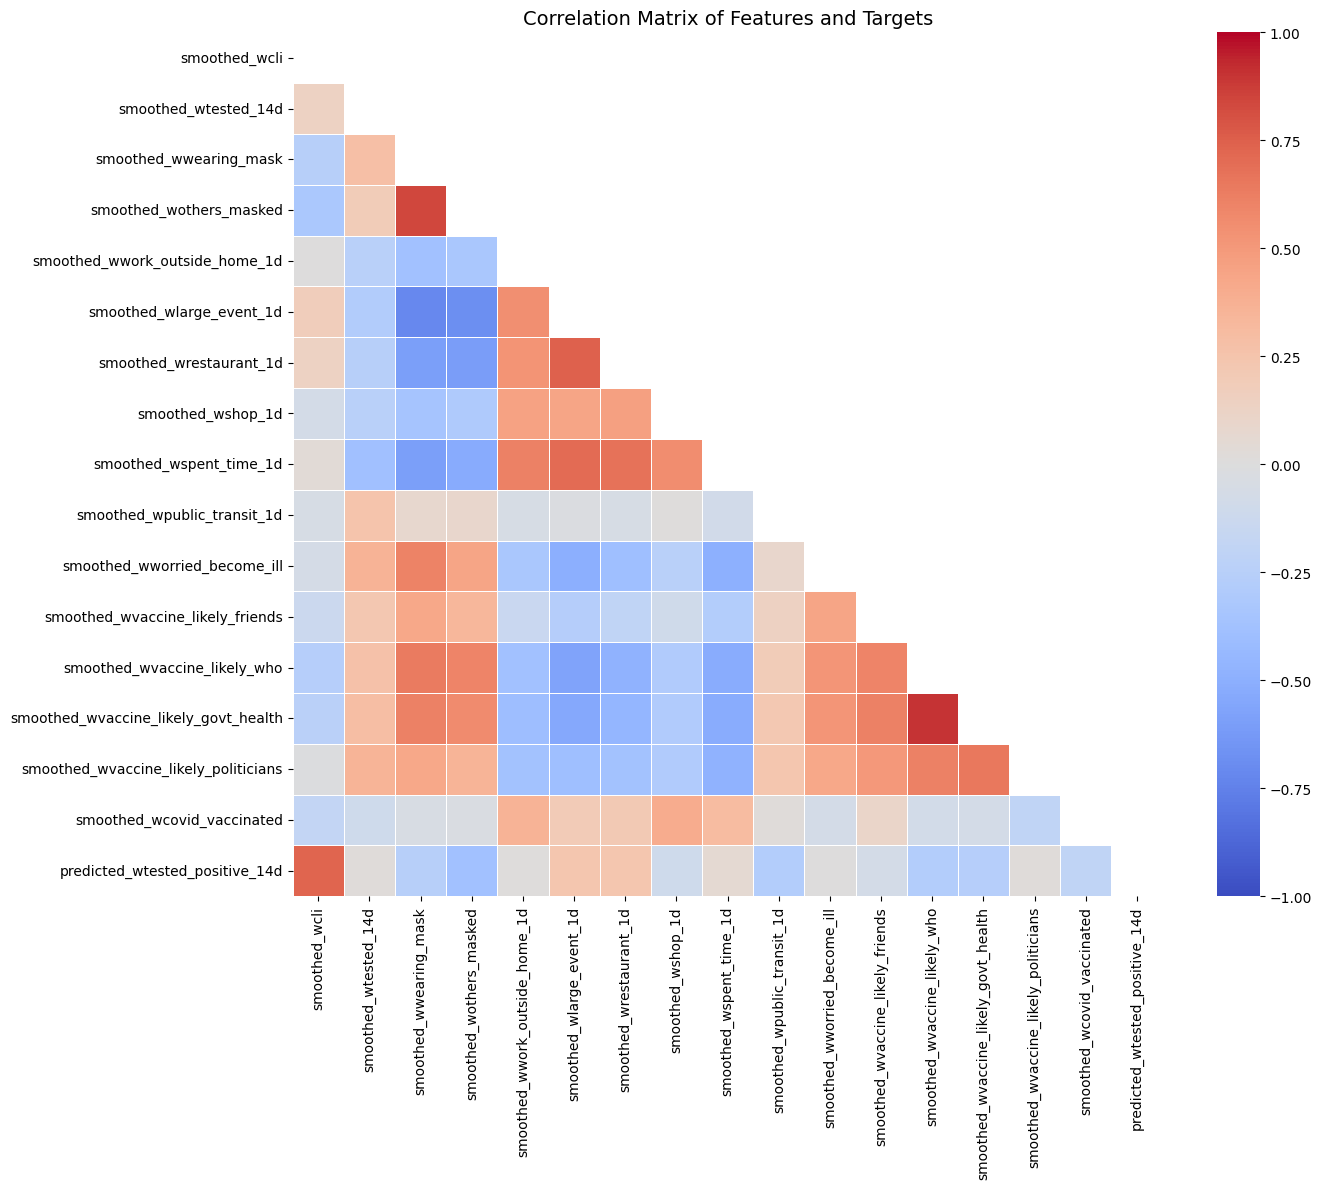

In [15]:
# === Feature Exploration: Correlation Matrix ===

corr_targets = ['smoothed_wcovid_vaccinated', 'predicted_wtested_positive_14d']
corr_matrix = data[features + corr_targets].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=False, mask=mask, cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Features and Targets', fontsize=14)
plt.tight_layout()
plt.show()

## Multicollinearity Detection

In [16]:
# === Identify Highly Correlated Feature Pairs (r > 0.8) ===

threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (|r| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} and {feat2}: {corr:.4f}")
else:
    print("\nNo feature pairs found with correlation above the threshold.")


Highly correlated feature pairs (|r| > 0.8):
smoothed_wothers_masked and smoothed_wwearing_mask: 0.8385
smoothed_wvaccine_likely_govt_health and smoothed_wvaccine_likely_who: 0.9054


## Target Variable Correlations

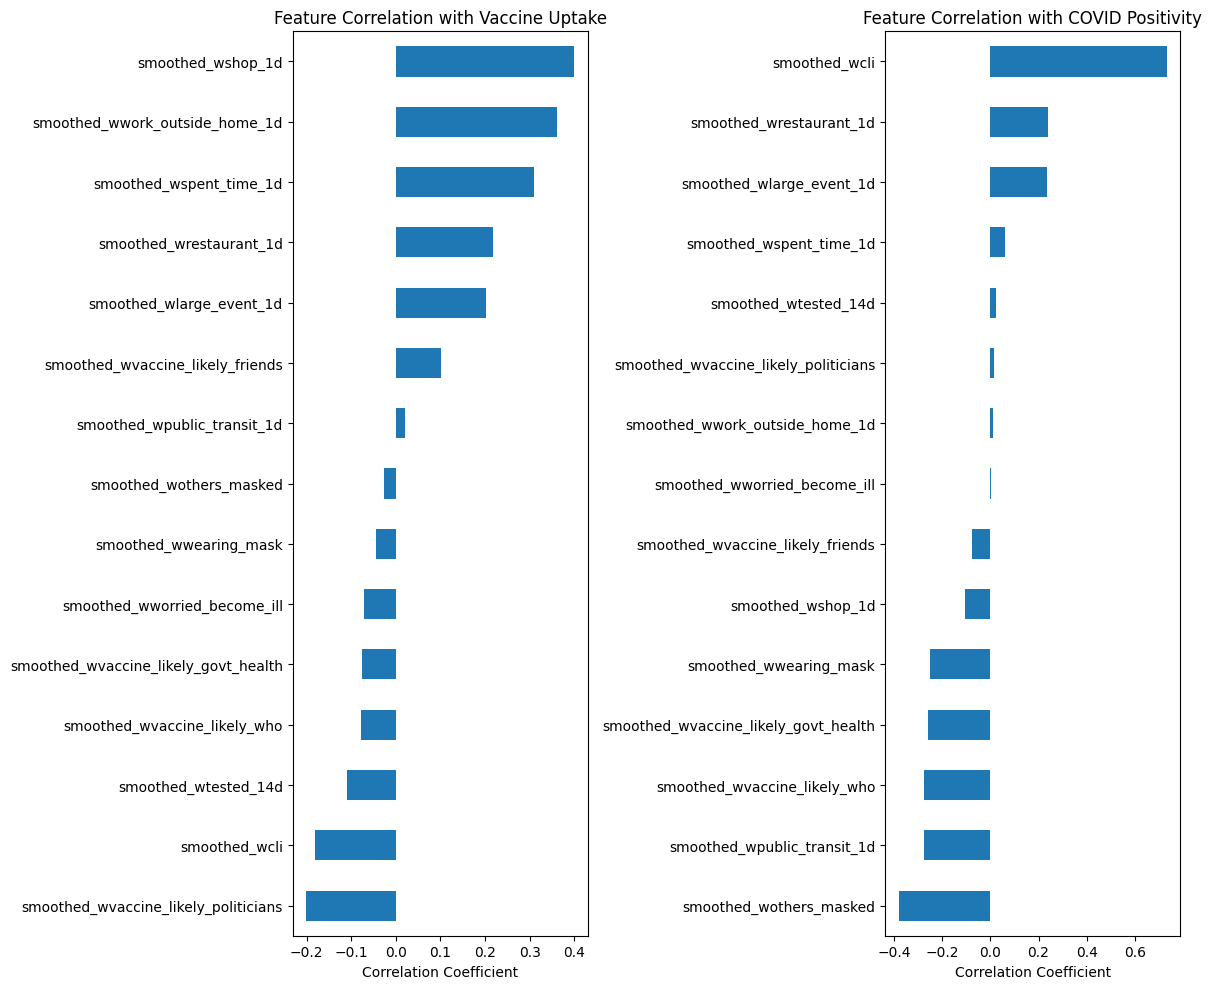

In [17]:
# === Correlations with Target Variables ===

target_correlations = corr_matrix[corr_targets].drop(corr_targets)

plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
target_correlations['smoothed_wcovid_vaccinated'].sort_values().plot(kind='barh')
plt.title('Feature Correlation with Vaccine Uptake')
plt.xlabel('Correlation Coefficient')

plt.subplot(1, 2, 2)
target_correlations['predicted_wtested_positive_14d'].sort_values().plot(kind='barh')
plt.title('Feature Correlation with COVID Positivity')
plt.xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()


#### Drop highly correlated features

In [36]:
features = [
    'smoothed_wcli', 'smoothed_wtested_14d',
    'smoothed_wwearing_mask',  # Keep this, drop smoothed_wothers_masked
    'smoothed_wwork_outside_home_1d', 'smoothed_wlarge_event_1d',
    'smoothed_wrestaurant_1d', 'smoothed_wshop_1d',
    'smoothed_wspent_time_1d', 'smoothed_wpublic_transit_1d',
    'smoothed_wworried_become_ill',
    'smoothed_wvaccine_likely_friends',  # Keep this, drop smoothed_wvaccine_likely_who
    'smoothed_wvaccine_likely_govt_health', 'smoothed_wvaccine_likely_politicians'
]

# Ensure all features exist in the dataset
missing_features = [f for f in features if f not in data.columns]
if missing_features:
    print(f"Warning: These features are not in the dataset: {missing_features}")
    features = [f for f in features if f in data.columns]

print(f"\nSelected features for modeling: {len(features)}")


Selected features for modeling: 13


## Skewness Check and Log Transform


Feature Skewness:
smoothed_wcli                           0.973375
smoothed_wtested_14d                    0.934783
smoothed_wwearing_mask                 -1.253957
smoothed_wwork_outside_home_1d          0.186641
smoothed_wlarge_event_1d                0.760975
smoothed_wrestaurant_1d                 0.235473
smoothed_wshop_1d                       0.328400
smoothed_wspent_time_1d                 0.269914
smoothed_wpublic_transit_1d             5.409867
smoothed_wworried_become_ill           -0.306324
smoothed_wvaccine_likely_friends        0.078359
smoothed_wvaccine_likely_govt_health    0.319968
smoothed_wvaccine_likely_politicians    0.569565
dtype: float64

Applying log1p transformation to 2 skewed features


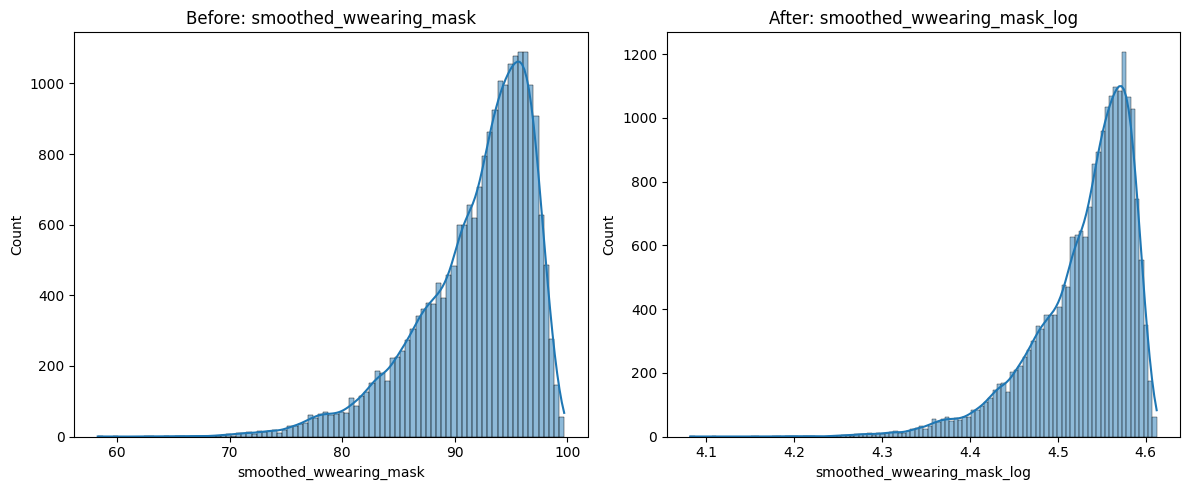

In [37]:
# === Apply Log Transformations for Highly Skewed Features ===

skewness = data[features].skew()
print("\nFeature Skewness:")
print(skewness)

skewed_features = skewness[abs(skewness) > 1].index

if len(skewed_features) > 0:
    print(f"\nApplying log1p transformation to {len(skewed_features)} skewed features")
    for feature in skewed_features:
        data[f"{feature}_log"] = np.log1p(data[feature])

    # Visual before/after for an example feature
    example_feature = skewed_features[0]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data[example_feature], kde=True)
    plt.title(f"Before: {example_feature}")
    plt.subplot(1, 2, 2)
    sns.histplot(data[f"{example_feature}_log"], kde=True)
    plt.title(f"After: {example_feature}_log")
    plt.tight_layout()
    plt.show()


## Standardize Features for Modeling

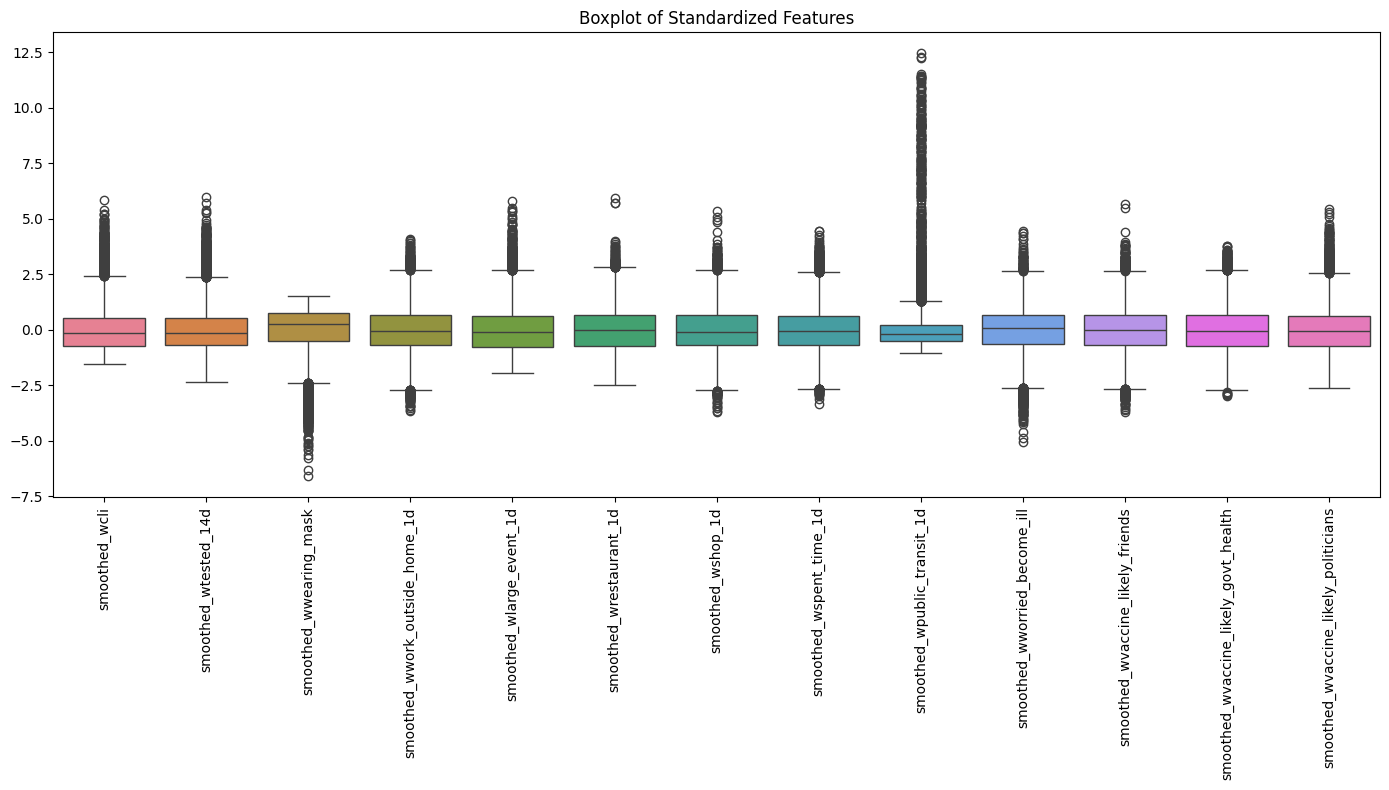

In [38]:
# === Standardize Features for Modeling ===

data_scaled = pd.DataFrame(
    StandardScaler().fit_transform(data[features]),
    columns=features,
    index=data.index
)

plt.figure(figsize=(14, 8))
sns.boxplot(data=data_scaled)
plt.xticks(rotation=90)
plt.title('Boxplot of Standardized Features')
plt.tight_layout()
plt.show()

## Summary & Save Transformed Dataset

In [39]:
# Summary statistics of the cleaned and transformed dataset
print("\nSummary Statistics after Cleaning and Transformation:")
print(data_scaled.describe())

# Save Cleaned and Transformed Dataset

processed_data = data.copy()
for feature in features:
    processed_data[f"{feature}_scaled"] = data_scaled[feature]

processed_data.to_csv("processed_covid_data.csv", index=False)

print("\nPhase II completed. Dataset cleaned, transformed, and saved for predictive modeling.")


Summary Statistics after Cleaning and Transformation:
       smoothed_wcli  smoothed_wtested_14d  smoothed_wwearing_mask  \
count   2.548100e+04          2.468800e+04            2.198500e+04   
mean    7.361692e-17          2.762966e-17            8.907236e-16   
std     1.000020e+00          1.000020e+00            1.000023e+00   
min    -1.518803e+00         -2.365291e+00           -6.591823e+00   
25%    -7.114788e-01         -6.960624e-01           -5.147636e-01   
50%    -1.619000e-01         -1.440933e-01            2.563232e-01   
75%     5.486911e-01          5.345306e-01            7.455543e-01   
max     5.855015e+00          6.002190e+00            1.532283e+00   

       smoothed_wwork_outside_home_1d  smoothed_wlarge_event_1d  \
count                    2.506600e+04              2.506600e+04   
mean                    -1.179230e-16              4.762275e-17   
std                      1.000020e+00              1.000020e+00   
min                     -3.638127e+00         

# Phase III: Predictive Modeling

## Load Processed Data & Define Targets

In [40]:
# Load processed dataset & define targets

try:
    processed_data = pd.read_csv('processed_covid_data.csv')
    print("Loaded cleaned dataset from processed_covid_data.csv")
except FileNotFoundError:
    print("Processed file not found, falling back to raw dataset.")
    processed_data = data.copy()  # fallback if file isn't found

# Define regression targets
targets = {
    'vaccine_uptake': 'smoothed_wcovid_vaccinated',  # lower missing rate
    'covid_positivity': 'predicted_wtested_positive_14d'  # semi-supervised target
}

Loaded cleaned dataset from processed_covid_data.csv


## Import Modeling Libraries

In [41]:
# Modeling Toolkit Setup

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Scikit-learn
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## PyTorch Regressor Architecture

In [42]:
# Define PyTorch Neural Network Regressor

import torch
import torch.nn as nn

class SimpleRegressor(nn.Module):
    def __init__(self, input_dim):
        super(SimpleRegressor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)


## Training and Evalutation Utilities

In [43]:
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 64

# Training and Evaluation Functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            y_true.append(targets.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    avg_loss = epoch_loss / len(loader)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return avg_loss, mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)


## Full Training Loop Across Targets

In [44]:
# PyTorch Model Training Loop Across Targets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

def run_torch_training(data, features, targets, num_epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    all_results = {}

    for target_name, target_col in targets.items():
        print(f"\n--- Training PyTorch NN for: {target_name} ---")

        # Preparing and cleaning data
        X = data[features].values
        y = data[target_col].values

        # Remove rows where X or y has any NaNs
        mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
        X, y = X[mask], y[mask]
        print(f"Training {target_name}: {len(y)} rows after dropping NaNs.")

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Split into train (80%) and test (20%) sets
        X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Further split train_full into train (80%) and validation (20%) sets
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

        # Initialize model, loss function, and optimizer
        model = SimpleRegressor(input_dim=X.shape[1]).to(device)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        # Training loop
        for epoch in range(num_epochs):
            # Record the start time of the epoch
            start_time = time.time()
            train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
            val_loss, _, _, _ = evaluate(model, val_loader, loss_fn, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Record the end time of the epoch
            end_time = time.time()

            # Print epoch number
            print(f"Epoch: {epoch+1}/{num_epochs}")
            # Print time taken for the epoch
            print(f"Time: {end_time - start_time:.2f}s")
            # Print training loss and accuracy
            print(f"Train Loss: {train_loss:.4f}")
            # Print validation loss and accuracy
            print(f"Val Loss: {val_loss:.4f}")
            # Print a separator line
            print("-" * 50)

        # Final evaluation metrics
        _, mse, mae, r2 = evaluate(model, test_loader, loss_fn, device)
        all_results[target_name] = {
            'MSE': mse,
            'MAE': mae,
            'R²': r2
        }

        # Loss plot
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Loss Curve - {target_name.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return all_results


## **Optional** - Call Function to Train Models


--- Training PyTorch NN for: vaccine_uptake ---
Training vaccine_uptake: 19420 rows after dropping NaNs.
Epoch: 1/10
Time: 1.31s
Train Loss: 97.4582
Val Loss: 35.4205
--------------------------------------------------
Epoch: 2/10
Time: 0.45s
Train Loss: 31.1078
Val Loss: 30.0497
--------------------------------------------------
Epoch: 3/10
Time: 0.45s
Train Loss: 28.3402
Val Loss: 28.1487
--------------------------------------------------
Epoch: 4/10
Time: 0.45s
Train Loss: 27.1216
Val Loss: 27.1912
--------------------------------------------------
Epoch: 5/10
Time: 0.46s
Train Loss: 26.4096
Val Loss: 26.7329
--------------------------------------------------
Epoch: 6/10
Time: 0.45s
Train Loss: 26.1590
Val Loss: 26.3503
--------------------------------------------------
Epoch: 7/10
Time: 0.45s
Train Loss: 25.8005
Val Loss: 26.1608
--------------------------------------------------
Epoch: 8/10
Time: 0.45s
Train Loss: 25.5454
Val Loss: 25.8554
-----------------------------------------

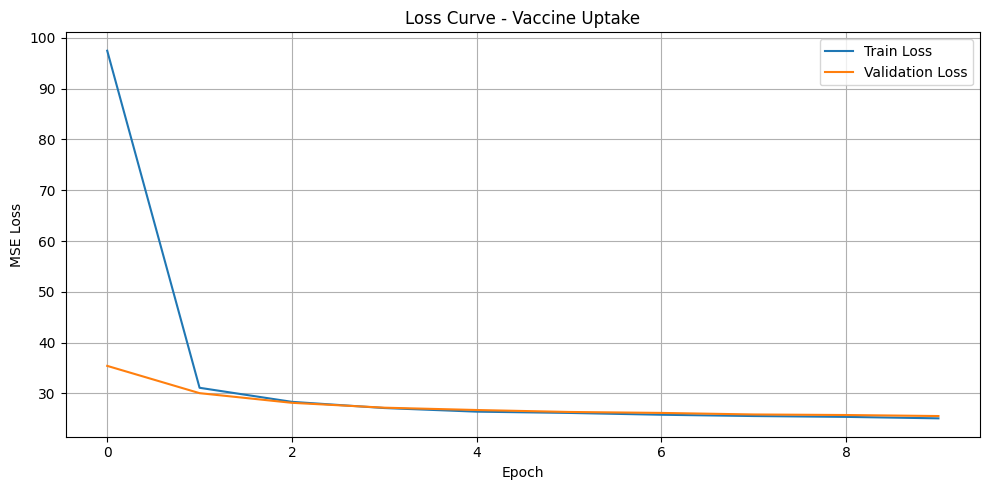


--- Training PyTorch NN for: covid_positivity ---
Training covid_positivity: 20551 rows after dropping NaNs.
Epoch: 1/10
Time: 0.64s
Train Loss: 145.6473
Val Loss: 27.6388
--------------------------------------------------
Epoch: 2/10
Time: 0.51s
Train Loss: 20.3964
Val Loss: 17.7214
--------------------------------------------------
Epoch: 3/10
Time: 0.51s
Train Loss: 14.6308
Val Loss: 13.8485
--------------------------------------------------
Epoch: 4/10
Time: 0.51s
Train Loss: 11.8043
Val Loss: 11.4642
--------------------------------------------------
Epoch: 5/10
Time: 0.49s
Train Loss: 10.0320
Val Loss: 10.1842
--------------------------------------------------
Epoch: 6/10
Time: 0.56s
Train Loss: 9.0743
Val Loss: 9.3840
--------------------------------------------------
Epoch: 7/10
Time: 0.52s
Train Loss: 8.5589
Val Loss: 8.9345
--------------------------------------------------
Epoch: 8/10
Time: 0.47s
Train Loss: 8.2098
Val Loss: 8.7503
------------------------------------------

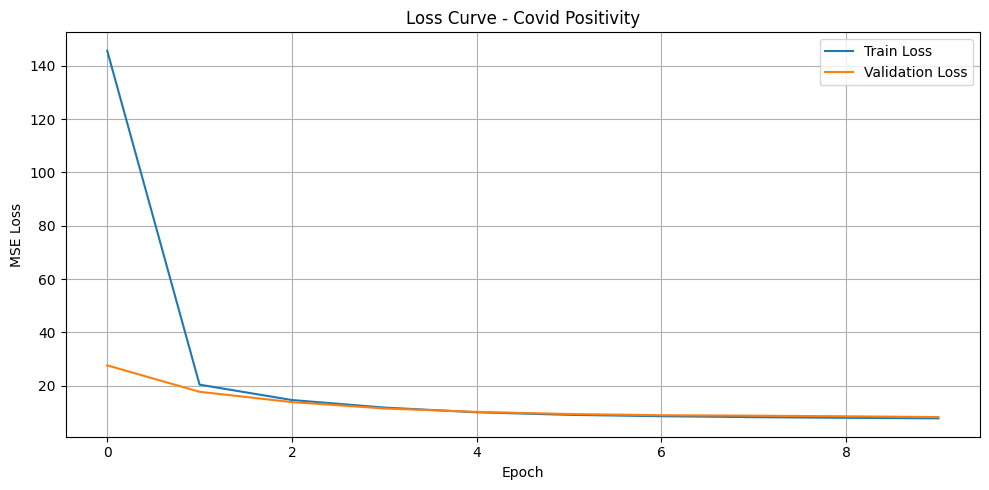


Final PyTorch Evaluation Results:

Target: vaccine_uptake
  MSE: 25.7197
  MAE: 4.0048
  R²:  0.3295

Target: covid_positivity
  MSE: 8.1198
  MAE: 2.0844
  R²:  0.7517


In [45]:
# Run the PyTorch Regressor on Processed Data

torch_results = run_torch_training(
    data=processed_data,
    features=[f"{f}_scaled" for f in features],  # Use scaled features
    targets=targets,
    num_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE
)

# View final metrics
print("\nFinal PyTorch Evaluation Results:")
for target, metrics in torch_results.items():
    print(f"\nTarget: {target}")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  R²:  {metrics['R²']:.4f}")


## Defining Models with Preprocessing Pipelines

In [46]:
# Define Model Pipelines

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

models = {
    'Ridge': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0, random_state=42))
    ]),
    'Lasso': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}


## Define K-Fold Evaluation Logic

In [47]:
# Cross-Validation Setup and Evaluation Function

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_models(X, y, models, cv):
    results = {}
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        mse_scores, mae_scores, r2_scores = [], [], []

        for train_idx, test_idx in cv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Handle missing labels
            mask_train, mask_test = ~np.isnan(y_train), ~np.isnan(y_test)
            X_train, y_train = X_train[mask_train], y_train[mask_train]
            X_test, y_test = X_test[mask_test], y_test[mask_test]

            if len(y_train) == 0 or len(y_test) == 0:
                print("Skipping fold due to missing labels.")
                continue

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse_scores.append(mean_squared_error(y_test, y_pred))
            mae_scores.append(mean_absolute_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))

        if mse_scores:
            results[name] = {
                'MSE': f"{np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}",
                'MAE': f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
                'R²': f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}",
                'model': model
            }

            print(f"  MSE: {results[name]['MSE']}")
            print(f"  MAE: {results[name]['MAE']}")
            print(f"  R²:  {results[name]['R²']}")
    return results


## Compare All Models (Classic + PyTorch)

In [48]:
# Compare Traditional Models + PyTorch

all_results = {}
model_features = features  # Can also use [f"{f}_scaled" for f in features]

# Ensure PyTorch models are already trained
if 'torch_results' not in globals():
    torch_results = run_torch_training(
        data=processed_data,
        features=model_features,
        targets=targets,
        num_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE
    )

# Compare models for each target
for target_name, target_col in targets.items():
    print(f"\n--- Predicting: {target_name.replace('_', ' ').title()} ---")

    X = processed_data[model_features].values
    y = processed_data[target_col].values

    standard_results = evaluate_models(X, y, models, cv)

    # Append PyTorch results
    standard_results['PyTorch Neural Network'] = {
        'MSE': f"{torch_results[target_name]['MSE']:.4f}",
        'MAE': f"{torch_results[target_name]['MAE']:.4f}",
        'R²':  f"{torch_results[target_name]['R²']:.4f}"
    }

    all_results[target_name] = standard_results

    # Create visual comparison DataFrame
    results_df = pd.DataFrame({
        model: [metrics['MSE'], metrics['MAE'], metrics['R²']]
        for model, metrics in standard_results.items() if 'MSE' in metrics
    }, index=['MSE', 'MAE', 'R²'])

    print(f"\nPerformance Comparison for {target_name}:\n")
    print(results_df)



--- Predicting: Vaccine Uptake ---

Evaluating Ridge...
  MSE: 32.4722 ± 0.5396
  MAE: 4.4420 ± 0.0360
  R²:  0.2690 ± 0.0066

Evaluating Lasso...
  MSE: 32.5751 ± 0.5610
  MAE: 4.4630 ± 0.0368
  R²:  0.2667 ± 0.0060

Evaluating RandomForest...
  MSE: 23.0239 ± 0.4519
  MAE: 3.6103 ± 0.0346
  R²:  0.4817 ± 0.0029

Evaluating GradientBoosting...
  MSE: 28.9220 ± 0.7488
  MAE: 4.1863 ± 0.0511
  R²:  0.3490 ± 0.0077

Performance Comparison for vaccine_uptake:

                Ridge             Lasso      RandomForest  GradientBoosting  \
MSE  32.4722 ± 0.5396  32.5751 ± 0.5610  23.0239 ± 0.4519  28.9220 ± 0.7488   
MAE   4.4420 ± 0.0360   4.4630 ± 0.0368   3.6103 ± 0.0346   4.1863 ± 0.0511   
R²    0.2690 ± 0.0066   0.2667 ± 0.0060   0.4817 ± 0.0029   0.3490 ± 0.0077   

    PyTorch Neural Network  
MSE                25.7197  
MAE                 4.0048  
R²                  0.3295  

--- Predicting: Covid Positivity ---

Evaluating Ridge...
  MSE: 11.2129 ± 0.1971
  MAE: 2.4971 ± 0.030